# Age Estimation using the YOLO algorithm

Authors: Isak Killingrød, Jon A B Larssen, Jon I J Skånøy

About

## Setup

### Imports

In [1]:
# %matplotlib inline
from tqdm.notebook import tqdm

In [2]:
import os
import shutil
import requests
import tarfile
from requests.auth import HTTPBasicAuth
import torch
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import re
import cv2
from concurrent.futures import ThreadPoolExecutor
import glob
from pathlib import Path
import yaml
import json
from datetime import datetime
import time
import optuna
from optuna.trial import TrialState
from ultralytics import YOLO
import platform
from facenet_pytorch import MTCNN
import warnings
import optuna
import random


### Config

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # TODO: TEMP DEV

In [4]:
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
if platform.system() == "Windows":
    print("Running on Windows")
    STORAGE = 'merged'
    MODEL_SIZES = ['n', 's', 'm', 'l','x']
    MODEL_VERSIONS = [8,9,10,11,12]
    IMAGE_SIZE = 416
elif platform.system() == "Linux":
    print("Running on Linux")
    STORAGE = 'YOLO_NB_SERVER'
    MODEL_SIZES = ['x', 'l', 'm', 's', 'n']
    MODEL_VERSIONS = [12,11,10,9,8]
    IMAGE_SIZE = 416
else:
    print(f"Running on {platform.system()}")
    STORAGE = 'YOLO_NB_UNKNOWN'

Running on Windows


In [ ]:
SPEEDRUN = True # Only for testing notebook functionality
USE_MAX_BATCH = True

In [7]:
RUN_OPTUNA = True
MERGE_DB = False
RUN_EXP_MODEL_SIZES = False
RUN_EXP_DATA_AUGMENTATION = False
RUN_EXP_MODEL_VERSIONS = False

In [8]:
NUM_WORKERS = os.cpu_count() // 3 # For preprocessing, not tuning or training

In [9]:
USERNAME = 'adiencedb'
PASSWORD = 'adience'

In [10]:
DATA_DIR = 'data'
BASE_URL = 'http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/'
ARCHIVE_URL = BASE_URL + "faces.tar.gz"
ARCHIVE_PATH = os.path.join(DATA_DIR, "faces.tar.gz")

### Functions

#### Utils

In [11]:
def show_sample_with_bbox(img_path, label_path, creator):
    """Display an image with its bounding box"""
    # TODO: Make it plot 3 samples in a 1 x 3 subplot
    # Load image
    img = Image.open(img_path)
    img_w, img_h = img.size
    
    # Load label
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:5])
    
    # Convert YOLO format to pixel coordinates
    x1 = int((x_center - width/2) * img_w)
    y1 = int((y_center - height/2) * img_h)
    x2 = int((x_center + width/2) * img_w)
    y2 = int((y_center + height/2) * img_h)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(img))
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    
    # Label with age category
    age_category = creator.age_categories[class_id]
    plt.title(f"Age Category: {age_category[0]}-{age_category[1]} years")
    plt.axis('off')
    plt.show()

In [12]:
def get_model_filename(version, size):

    version = str(version).lower()
    size = size.lower()

    if version == '9':
        model_map = {
            'n': 'yolov9t.pt',
            's': 'yolov9s.pt',
            'm': 'yolov9m.pt',
            'l': 'yolov9c.pt',
            'x': 'yolov9e.pt',
        }
        return model_map[size]

    if version in ['8', '10']:
        return f'yolov{version}{size}.pt'
    elif version in ['11', '12']:
        return f'yolo{version}{size}.pt'

In [13]:
def check_default_boxes(base_dir='data/age_dataset_tune'):

    for split in ['train', 'val']:
        label_dir = os.path.join(base_dir, 'labels', split)
        label_files = glob.glob(os.path.join(label_dir, '*.txt'))
        
        if not label_files:
            print(f"  No label files found in {label_dir}. Skipping...")
            continue
        
        default_boxes = 0
        for file in label_files:
            with open(file, 'r') as f:
                parts = f.readline().strip().split()
                if len(parts) == 5:
                    _, x, y, w, h = map(float, parts)
                    if abs(x - 0.5) < 0.05 and abs(y - 0.5) < 0.05 and abs(w - 0.8) < 0.05 and abs(h - 0.8) < 0.05:
                        default_boxes += 1
        
        total_files = len(label_files)
        percent = (default_boxes / total_files) * 100
        print(f"  {split.capitalize()} set: {default_boxes}/{total_files} default boxes ({percent:.2f}%)")

#### Tuning

In [ ]:
def make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial):
    def objective(trial):
        params = {
            'lr0': trial.suggest_float('lr0', 1e-5, 1e-1, log=True),
            'lrf': trial.suggest_float('lrf', 0.01, 1.0),
            'momentum': trial.suggest_float('momentum', 0.6, 0.98),
            'weight_decay': trial.suggest_float('weight_decay', 0.0001, 0.001, log=True),
            'warmup_epochs': trial.suggest_int('warmup_epochs', 1, 5),
            'warmup_momentum': trial.suggest_float('warmup_momentum', 0.5, 0.95),
            'box': trial.suggest_float('box', 0.02, 0.2),
            'cls': trial.suggest_float('cls', 0.2, 4.0),
            'hsv_h': trial.suggest_float('hsv_h', 0.0, 0.1),
            'hsv_s': trial.suggest_float('hsv_s', 0.5, 0.9),
            'hsv_v': trial.suggest_float('hsv_v', 0.5, 0.9),
            'degrees': trial.suggest_float('degrees', 0.0, 45.0),
            'translate': trial.suggest_float('translate', 0.0, 0.5),
            'scale': trial.suggest_float('scale', 0.0, 0.5),
            'fliplr': trial.suggest_float('fliplr', 0.0, 0.5),
            'mosaic': trial.suggest_float('mosaic', 0.0, 1.0),
            'batch': trial.suggest_int('batch', 32, 32) if not SPEEDRUN else 0.9,  # TEMPDEV
            'imgsz': trial.suggest_int('imgsz', imgsz, imgsz),
            'optimizer': 'AdamW',
            'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
            
        }

        try:
            model = YOLO(model_path)
            results = model.train(
                data=data_yaml,
                cache='disk',
                workers=1,
                epochs=epochs_per_trial,
                device=device,
                verbose=False,
                plots=True if not SPEEDRUN else False,
                **params
            )
            return float(results.fitness) if hasattr(results, 'fitness') else 0.0
        except Exception as e:
            print(f"❌ Trial failed with error: {e}")
            return 0.0
    return objective

In [15]:
def run_optuna_tuning(
    data_yaml,
    model_size='n',
    output_dir='runs/tune_optuna',
    imgsz=416,
    n_trials=40,
    epochs_per_trial=30,
    model_version=8,
    device='0'):

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_name = f"optuna_v{model_version}_{model_size}_{timestamp}"
    output_path = os.path.join(output_dir, run_name)
    os.makedirs(output_path, exist_ok=True)

    try:
        model_path = get_model_filename(model_version, model_size)
    except ValueError as e:
        print(f"❌ Invalid model request: {e}")
        return {}, 0.0

    study_name = f"yolo_v{model_version}{model_size}"
    study_storage = f"sqlite:///{STORAGE}.db"

    try:
        summaries = optuna.study.get_all_study_summaries(storage=study_storage)
    except Exception as e:
        print(f"❌ Failed to load Optuna study summaries: {e}")
        return {}, 0.0

    existing_study = next((s for s in summaries if s.study_name == study_name), None)
    existing_trials = existing_study.n_trials if existing_study else 0

    if existing_trials >= n_trials:
        print(f"⏩ Skipping tuning: {existing_trials} completed trials already (target was {n_trials}).")
        try:
            study = optuna.load_study(study_name=study_name, storage=study_storage)
            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Study exists but has no valid completed trials.")
                return {}, 0.0
            best_params = study.best_params
            best_value = study.best_value
        except ValueError as e:
            print(f"⚠️ Could not retrieve best trial: {e}")
            return {}, 0.0
    else:
        remaining_trials = n_trials - existing_trials
        print(f"🔄 Starting/resuming tuning: {remaining_trials} trials needed.")
        try:
            study = optuna.create_study(
                direction='maximize',
                study_name=study_name,
                storage=study_storage,
                load_if_exists=True
            )
            objective = make_objective(model_path, data_yaml, imgsz, device, epochs_per_trial)
            study.optimize(objective, n_trials=remaining_trials)

            if len(study.trials) == 0 or study.best_trial is None:
                print("⚠️ Tuning completed but no valid trials found.")
                return {}, 0.0

            best_params = study.best_params
            best_value = study.best_value
        except Exception as e:
            print(f"❌ Failed during tuning process: {e}")
            return {}, 0.0

    with open(os.path.join(output_path, f'best_params_v{model_version}_{model_size}.json'), 'w') as f:
        json.dump(best_params, f, indent=4)

    print(f"\n✅ Best result for YOLOv{model_version}-{model_size}: {best_value:.4f}")
    return best_params, best_value

In [16]:
def run_optuna_tuning_multi(
    base_dataset_dir='data/age_dataset_tune',
    model_sizes=['n', 's', 'm', 'l', 'x'],
    model_versions=[8, 9, 10, 11, 12],
    imgsz=416,
    n_trials=10,
    epochs_per_trial=30,
    device='0',
    output_base='runs/age_exp'
):

    data_yaml = os.path.join(base_dataset_dir, "data.yaml")

    if not data_yaml:
        print(f"⚠️ No datasets found in: {base_dataset_dir}")
        return

    print(f"\n📂 Evaluating dataset: {data_yaml}")

    for version in model_versions:
        for size in model_sizes:
            try:
                model_filename = get_model_filename(version, size)
            except ValueError as e:
                print(f"⏭️ Skipping unsupported model: YOLOv{version}-{size} ({e})")
                continue

            dataset_name = Path(data_yaml).parent.name
            run_name = f"v{version}_{size}"
            output_dir = os.path.join(output_base, run_name)

            print(f"\n{'='*100}")
            print(f"🧪 Tuning: YOLOv{version}-{size} on dataset {dataset_name}")
            print(f"{'='*100}")

            best_params, best_value = run_optuna_tuning(
                data_yaml=data_yaml,
                model_size=size,
                model_version=version,
                output_dir=output_dir,
                imgsz=imgsz,
                n_trials=n_trials,
                epochs_per_trial=epochs_per_trial,
                device=device
            )

In [17]:
def merge_optuna_databases(source_db_paths, target_db_path):
    """
    Merge Optuna studies from multiple databases into a target database.

    Args:
        source_db_paths (list): List of SQLite database URIs to merge.
        target_db_path (str): Target SQLite database URI.
    """
    target_storage = optuna.storages.RDBStorage(url=target_db_path)

    for db_path in source_db_paths:
        source_storage = optuna.storages.RDBStorage(url=db_path)
        study_summaries = optuna.get_all_study_summaries(storage=source_storage)
        
        for summary in study_summaries:
            study = optuna.load_study(study_name=summary.study_name, storage=source_storage)
            
            try:
                new_study = optuna.create_study(
                    study_name=study.study_name,
                    storage=target_storage,
                    direction=study.direction
                )
            except optuna.exceptions.DuplicatedStudyError:
                new_study = optuna.load_study(
                    study_name=study.study_name,
                    storage=target_storage
                )
            
            for trial in study.get_trials(deepcopy=True, states=(TrialState.COMPLETE,)):
                new_study.add_trial(trial)

In [18]:
def extract_study_trials_to_dataframe(db_paths, filter_study_name=None, sort_by_value=True):
    """
    Extract trials from Optuna databases into a DataFrame.

    Args:
        db_paths (list): List of database URIs.
        filter_study_name (str, optional): Only include studies matching this name. Default: None.
        sort_by_value (bool): Whether to sort trials by Value (ascending).

    Returns:
        pd.DataFrame: Trials information as a DataFrame.
    """
    study_infos = []

    for db_path in db_paths:
        storage = optuna.storages.RDBStorage(url=db_path)
        summaries = optuna.get_all_study_summaries(storage=storage)

        for summary in summaries:
            if filter_study_name and summary.study_name != filter_study_name:
                continue
            
            study = optuna.load_study(study_name=summary.study_name, storage=storage)
            completed_trials = [t for t in study.get_trials(deepcopy=False) if t.state == TrialState.COMPLETE]
            completed_trials.sort(key=lambda x: x.value)
            
            for rank, trial in enumerate(completed_trials, 1):
                study_infos.append({
                    "Database": db_path,
                    "Study Name": summary.study_name,
                    "Rank": rank,
                    "Trial Number": trial.number,
                    "Value": trial.value,
                    **trial.params
                })

    df = pd.DataFrame(study_infos)
    
    if sort_by_value:
        df = df.sort_values(by=["Value"], ascending=False)

    return df

#### Training

In [19]:
def get_best_params(study_path=None, study_name=None, db_path=None):
    
    if study_path and os.path.exists(study_path):
        print(f"Loading Optuna study from file: {study_path}")
        study = optuna.load_study(study_name="loaded_study", storage=study_path)
    elif db_path and study_name:
        print(f"Loading Optuna study from database: {db_path}, study name: {study_name}")
        study = optuna.load_study(study_name=study_name, storage=db_path)
    else:
        raise ValueError("Either study_path or (db_path and study_name) must be provided")
    
    return study.best_params, study.best_value

In [ ]:
def train_model(data_yaml, model_size, model_v, training_params, run_id, epochs=100, device='0', project='runs/multi_runs', base_name=None):

    start_time = time.time()
    random_seed = random.randint(0, 10000)  # Generate a random seed for this run
    print(f"Run {run_id}: Using random seed {random_seed}")
    
    # Set seeds
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True if not SPEEDRUN else False # TEMPDEV
    
    if base_name is None:
        base_name = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    name = f"{base_name}_run{run_id}"

    model_path = get_model_filename(model_v, model_size)
    print(f"Run {run_id}: Using model {model_path}")
    model = YOLO(model_path)
    
    training_params['seed'] = random_seed

    # Train with the best parameters
    print(f"\nRun {run_id}: Starting training for {epochs} epochs...")
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        cache='disk',
        device=device,
        project=project,
        name=name,
        verbose=False,
        **training_params
    )
    
    training_time = time.time() - start_time
    run_dir = os.path.join(project, name)
    print(f"Run {run_id}: Training completed in {training_time / 3600:.2f} hours. Results saved to {run_dir}")
    
    # Save the training time to a file
    with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
        f.write(f"Training Time: {training_time:.2f} seconds ({training_time / 3600:.2f} hours)\n")
        f.write(f"Run ID: {run_id}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    return results, run_dir, training_time

In [21]:
def get_label_path(img_path):

    img_path = Path(img_path)
    
    # Try common YOLO folder structures:
    # 1. Standard YOLOv5/YOLOv8 structure: 'images/train' -> 'labels/train'
    if 'images' in img_path.parts:
        idx = img_path.parts.index('images')
        label_path = Path(*img_path.parts[:idx], 'labels', *img_path.parts[idx+1:])
        label_path = label_path.with_suffix('.txt')
        if label_path.exists():
            return str(label_path)
    
    # 2. Replace image extension with .txt in the same directory
    label_path = img_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # 3. Check for a 'labels' directory at the same level as the image directory
    parent_dir = img_path.parent
    label_dir = parent_dir.parent / 'labels' / parent_dir.name
    label_path = label_dir / img_path.name
    label_path = label_path.with_suffix('.txt')
    if label_path.exists():
        return str(label_path)
    
    # 4. Default fallback: just replace extension
    return str(img_path.with_suffix('.txt'))

In [22]:
def calculate_accuracy(model, data_yaml, conf_threshold=0.1):

    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names
    class_names = data_config['names']
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize counters
    correct_predictions = 0
    total_images = 0
    results_dict = {
        "per_image": [],
        "per_class": {class_id: {"correct": 0, "total": 0} for class_id in class_names}
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Evaluating images"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold, verbose=False)[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # Sort predictions by confidence (descending)
        if len(predictions) > 0:
            # Sort by confidence (5th column, index 4)
            predictions = predictions[predictions[:, 4].argsort()[::-1]]
            
            # Get the most confident prediction
            most_confident_pred = predictions[0]
            pred_class_id = int(most_confident_pred[5])
            
            # Check if prediction matches any ground truth
            is_correct = pred_class_id in ground_truth_classes
            
            if is_correct:
                correct_predictions += 1
            
            # Update per-class statistics
            for gt_class in set(ground_truth_classes):  # Count each class only once per image
                results_dict["per_class"][gt_class]["total"] += 1
                if is_correct and pred_class_id == gt_class:
                    results_dict["per_class"][gt_class]["correct"] += 1
            
            # Store per-image results
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": class_names[pred_class_id],
                "confidence": float(most_confident_pred[4]),
                "correct": is_correct
            })
        else:
            # No detections
            results_dict["per_image"].append({
                "image_path": img_path,
                "ground_truth": [class_names[cls] for cls in ground_truth_classes],
                "prediction": "none",
                "confidence": 0.0,
                "correct": False
            })
            
            # Update per-class statistics (all are incorrect since no detection)
            for gt_class in set(ground_truth_classes):
                results_dict["per_class"][gt_class]["total"] += 1
        
        total_images += 1
    
    # Calculate accuracy
    accuracy = correct_predictions / total_images if total_images > 0 else 0
    
    # Calculate per-class accuracy
    for class_id in results_dict["per_class"]:
        class_total = results_dict["per_class"][class_id]["total"]
        class_correct = results_dict["per_class"][class_id]["correct"]
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        results_dict["per_class"][class_id]["accuracy"] = class_accuracy
    
    results_dict["overall_accuracy"] = accuracy
    results_dict["total_images"] = total_images
    results_dict["correct_predictions"] = correct_predictions
    
    return accuracy, results_dict

In [23]:
def plot_confusion_matrix(cm, class_names, output_path, title='Confusion Matrix', normalize=False, figsize=(14, 12)):

    plt.figure(figsize=figsize)
    
    # Use a different colormap for normalized vs raw
    cmap = 'Blues' if normalize else 'Blues'
    
    # Create heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='.2f' if normalize else 'd', 
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        annot_kws={"size": 16}
    )
    
    # Set labels and title
    plt.ylabel('Ground Truth', fontsize=18)
    plt.xlabel('Prediction', fontsize=18)
    plt.title(title, fontsize=20)
    
    # Rotate tick labels if there are many classes
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14, rotation=0)
    
    # Tight layout to ensure everything fits
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.close()

In [24]:
def generate_confusion_matrix(model, data_yaml, conf_threshold=0.1, output_dir=None):

    # Start timing
    start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Get the class names and number of classes
    class_names = data_config['names']
    num_classes = len(class_names)
    
    # Get validation dataset path
    val_path = data_config.get('val')
    if not val_path:
        raise ValueError("Validation set path not found in data.yaml")
    
    # If val_path is relative, make it absolute based on the data.yaml location
    data_dir = os.path.dirname(os.path.abspath(data_yaml))
    if not os.path.isabs(val_path):
        val_path = os.path.join(data_dir, val_path)
    
    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []
    
    # Handle if val_path is a file with paths
    if os.path.isfile(val_path) and val_path.endswith('.txt'):
        with open(val_path, 'r') as f:
            for line in f:
                img_path = line.strip()
                # Convert relative paths to absolute if needed
                if not os.path.isabs(img_path):
                    img_path = os.path.join(data_dir, img_path)
                if os.path.exists(img_path):
                    image_files.append(img_path)
    # Handle if val_path is a directory
    elif os.path.isdir(val_path):
        for root, _, files in os.walk(val_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    image_files.append(os.path.join(root, file))
    else:
        raise ValueError(f"Invalid validation path: {val_path}")
    
    if not image_files:
        raise ValueError(f"No images found in validation set path: {val_path}")
    
    print(f"Found {len(image_files)} images in the validation set")
    
    # Initialize confusion matrix (rows: ground truth, columns: predictions)
    # Add an extra class for "no detection"
    confusion_matrix = np.zeros((num_classes, num_classes + 1), dtype=int)
    
    # Results dictionary for detailed information
    results_dict = {
        "per_image": [],
        "confusion_matrix": None,
        "class_names": class_names,
    }
    
    # Process each image
    for img_path in tqdm(image_files, desc="Generating confusion matrix"):
        # Get corresponding label file
        label_path = get_label_path(img_path)
        
        if not os.path.exists(label_path):
            print(f"Warning: No label file found for {img_path}")
            continue
        
        # Read ground truth labels
        ground_truth_classes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id x y w h
                    class_id = int(float(parts[0]))
                    ground_truth_classes.append(class_id)
        
        if not ground_truth_classes:
            print(f"Warning: No valid labels in {label_path}")
            continue
        
        # Run inference
        results = model(img_path, conf=conf_threshold,verbose=False )[0]
        
        # Get predictions
        predictions = results.boxes.data.cpu().numpy()
        
        # For each ground truth class in the image
        for gt_class in ground_truth_classes:
            if gt_class >= num_classes:
                print(f"Warning: Ground truth class {gt_class} is out of range in {label_path}")
                continue
                
            # Check if there are any predictions
            if len(predictions) > 0:
                # Sort by confidence (descending)
                predictions = predictions[predictions[:, 4].argsort()[::-1]]
                
                # Get the most confident prediction
                most_confident_pred = predictions[0]
                pred_class_id = int(most_confident_pred[5])
                confidence = float(most_confident_pred[4])
                
                # Update confusion matrix
                confusion_matrix[gt_class, pred_class_id] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": pred_class_id,
                    "confidence": confidence,
                    "correct": pred_class_id == gt_class
                })
            else:
                # No detection (represented by the last column)
                confusion_matrix[gt_class, -1] += 1
                
                # Store per-image results
                results_dict["per_image"].append({
                    "image_path": img_path,
                    "ground_truth": gt_class,
                    "prediction": "none",
                    "confidence": 0.0,
                    "correct": False
                })
    
    # Calculate processing time
    end_time = time.time()
    processing_time = end_time - start_time
    
    # Store raw confusion matrix in results
    results_dict["confusion_matrix"] = confusion_matrix.tolist()
    results_dict["processing_time"] = processing_time
    
    # Calculate normalized confusion matrix (by row/ground truth)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    norm_confusion_matrix = np.zeros_like(confusion_matrix, dtype=float)
    for i in range(num_classes):
        if row_sums[i] > 0:
            norm_confusion_matrix[i] = confusion_matrix[i] / row_sums[i]
    
    # Save outputs if directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert class_names to a list if it's a dictionary
        if isinstance(class_names, dict):
            # If class_names is a dictionary, convert it to a list
            max_id = max(class_names.keys())
            class_names_list = [class_names.get(i, f"unknown_{i}") for i in range(max_id + 1)]
        else:
            # If class_names is already a list
            class_names_list = class_names
        
        # Create class labels for output
        class_labels = class_names_list.copy()
        header_labels = class_names_list + ['no_detection']
        
        # Save raw numbers to CSV
        raw_cm_path = os.path.join(output_dir, 'confusion_matrix_raw.csv')
        with open(raw_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [str(x) for x in confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save normalized matrix to CSV
        norm_cm_path = os.path.join(output_dir, 'confusion_matrix_normalized.csv')
        with open(norm_cm_path, 'w') as f:
            # Write header
            f.write(',' + ','.join(header_labels) + '\n')
            
            # Write each row
            for i, class_label in enumerate(class_labels):
                if i < norm_confusion_matrix.shape[0]:  # Make sure we don't go out of bounds
                    row = [class_label] + [f"{x:.4f}" for x in norm_confusion_matrix[i]]
                    f.write(','.join(row) + '\n')
        
        # Save detailed results to JSON
        results_path = os.path.join(output_dir, 'confusion_matrix_results.json')
        with open(results_path, 'w') as f:
            json.dump(results_dict, f, indent=4)
        
        # Create and save visualizations
        plot_confusion_matrix(
            confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_raw.png'),
            title='Confusion Matrix (Raw Counts)',
            normalize=False
        )
        
        plot_confusion_matrix(
            norm_confusion_matrix, 
            header_labels,
            os.path.join(output_dir, 'confusion_matrix_normalized.png'),
            title='Confusion Matrix (Normalized by Row)',
            normalize=True
        )
        
        # Save processing time information
        time_path = os.path.join(output_dir, 'processing_time.txt')
        with open(time_path, 'w') as f:
            f.write(f"Confusion Matrix Generation Time: {processing_time:.2f} seconds\n")
            f.write(f"Images Processed: {len(image_files)}\n")
            f.write(f"Average Time Per Image: {processing_time/len(image_files):.4f} seconds\n")
            f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        print(f"Confusion matrix results saved to {output_dir}")
        print(f"Processing time: {processing_time:.2f} seconds")
    
    return confusion_matrix, norm_confusion_matrix, results_dict

In [25]:
def read_metrics_from_run(run_dir):

    metrics_file = os.path.join(run_dir, 'results.csv')
    if not os.path.exists(metrics_file):
        print(f"Warning: Metrics file not found at {metrics_file}")
        return {}
    
    # Read the CSV file and get the last row (final epoch metrics)
    try:
        df = pd.read_csv(metrics_file)
        final_metrics = df.iloc[-1].to_dict()
        return final_metrics
    except Exception as e:
        print(f"Error reading metrics file: {e}")
        return {}

In [26]:
def write_execution_time_log(filepath, overall_start_time, overall_end_time, num_runs, epochs):

    overall_time = overall_end_time - overall_start_time
    overall_hours = overall_time / 3600.0

    with open(filepath, 'w') as f:
        f.write(f"Overall Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)\n")
        f.write(f"Start Time: {datetime.fromtimestamp(overall_start_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"End Time: {datetime.fromtimestamp(overall_end_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of Runs: {num_runs}\n")
        f.write(f"Epochs per Run: {epochs}\n")

In [27]:
def run_multiple_trainings(
    data_yaml: yaml,
    extra_train_params: dict,
    model_size: str = 'n',
    study_path=None,
    study_name=None,
    db_path=None,
    num_runs=5,
    model_v = "8",
    epochs=100,
    device='0',
    project='runs/multi_runs',
    conf_threshold=0.1):

    # Overall start time
    overall_start_time = time.time()
    
    # Load dataset information
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    
    # Display dataset information
    print(f"Dataset information:")
    print(f"  Classes: {data_config.get('nc', 0)}")
    for idx, class_name in enumerate(data_config['names']):
        print(f"  Class {idx}: {class_name}")
    
    best_params, best_value = get_best_params(study_path, study_name, db_path)
    print(f"Best parameters (mAP50-95: {best_value:.4f}):")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    base_name = f"multi_run_{timestamp}"
    
    os.makedirs(project, exist_ok=True)
    aggregate_dir = os.path.join(project, f"{base_name}_aggregate")
    os.makedirs(aggregate_dir, exist_ok=True)
    
    best_params_path = os.path.join(aggregate_dir, 'best_params.json')
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)
    
    merged_params = {**best_params, **extra_train_params}
    with open(os.path.join(aggregate_dir, 'merged_training_params.json'), 'w') as f:
        json.dump(merged_params, f, indent=4)
    
    # Track metrics across runs
    all_metrics = []
    all_accuracies = []
    training_times = []
    
    # Run multiple training iterations
    for run_id in range(1, num_runs + 1):
        print(f"\n{'='*80}")
        print(f"Starting Run {run_id}/{num_runs}")
        print(f"{'='*80}")
        
        results, run_dir, training_time = train_model(
            data_yaml=data_yaml,
            model_size=model_size,
            model_v = model_v,
            training_params=merged_params,
            run_id=run_id,
            epochs=epochs,
            device=device,
            project=project,
            base_name=base_name
        )
        
        training_times.append(training_time)
        
        # Get the path to the LAST weights
        weights_path = os.path.join(run_dir, 'weights', 'last.pt')
        if not os.path.exists(weights_path):
            print(f"Warning: Last weights not found at {weights_path}")
            continue
        print(f"\nRun {run_id}: Loading model from {weights_path} for evaluation")
        trained_model = YOLO(weights_path) 
        
        print(f"Run {run_id}: Calculating accuracy metrics")
        accuracy, accuracy_results = calculate_accuracy(trained_model, data_yaml, conf_threshold)
        
        print(f"Run {run_id}: Generating confusion matrix")
        cm_dir = os.path.join(run_dir, 'confusion_matrix')
        raw_cm, norm_cm, cm_results = generate_confusion_matrix(
            trained_model, 
            data_yaml, 
            conf_threshold=conf_threshold,
            output_dir=cm_dir
        )
        
        # Also make a copy of the confusion matrix visualizations in the aggregate directory
        for file_name in ['confusion_matrix_raw.png', 'confusion_matrix_normalized.png']:
            src = os.path.join(cm_dir, file_name)
            if os.path.exists(src):
                dst = os.path.join(aggregate_dir, f'{file_name.split(".")[0]}_run{run_id}.png')
                shutil.copy(src, dst)
        
        # Read standard YOLO metrics from results.csv
        yolo_metrics = read_metrics_from_run(run_dir)
        
        # Combine metrics
        combined_metrics = {
            'run_id': run_id,
            'accuracy': accuracy,
            'training_time': training_time,
            **yolo_metrics
        }
        all_metrics.append(combined_metrics)
        all_accuracies.append(accuracy_results)
        
        # Save accuracy results to JSON
        accuracy_results_path = os.path.join(run_dir, 'accuracy_results.json')
        with open(accuracy_results_path, 'w') as f:
            json.dump(accuracy_results, f, indent=4)
        
        # Also make a copy in the aggregate directory
        shutil.copy(accuracy_results_path, os.path.join(aggregate_dir, f'accuracy_results_run{run_id}.json'))
        
        # Print metrics summary for this run
        print(f"\nRun {run_id} Results (using last.pt weights):")
        print(f"  Training Time: {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy_results['correct_predictions']}/{accuracy_results['total_images']})")
        print("  YOLO Metrics:")
        for key, value in yolo_metrics.items():
            if key.startswith('metrics/'):
                print(f"    {key.replace('metrics/', '')}: {value:.4f}")
    
    # Calculate average metrics
    if all_metrics:
        metrics_df = pd.DataFrame(all_metrics)
        
        mean_metrics = metrics_df.mean(numeric_only=True)
        std_metrics = metrics_df.std(numeric_only=True)
        
        # Save all metrics to CSV
        metrics_df.to_csv(os.path.join(aggregate_dir, 'all_runs_metrics.csv'), index=False)
        
        # Save average metrics to CSV
        avg_metrics_df = pd.DataFrame({
            'metric': mean_metrics.index,
            'mean': mean_metrics.values,
            'std': std_metrics.values
        })
        avg_metrics_df.to_csv(os.path.join(aggregate_dir, 'average_metrics.csv'), index=False)
        
        # Calculate and save average training time
        avg_training_time = sum(training_times) / len(training_times)
        avg_training_hours = avg_training_time / 3600.0
        std_training_time = np.std(training_times)
        
        # Save training time statistics
        time_stats_path = os.path.join(aggregate_dir, 'training_time_stats.txt')
        with open(time_stats_path, 'w') as f:
            f.write(f"Training Time Statistics\n")
            f.write(f"======================\n\n")
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours)\n")
            f.write(f"Standard Deviation: {std_training_time:.2f} seconds\n\n")
            f.write(f"Individual Run Times:\n")
            for i, time_val in enumerate(training_times):
                f.write(f"  Run {i+1}: {time_val:.2f} seconds ({time_val/3600:.2f} hours)\n")
        
        # Print individual values for key metrics to verify stochasticity
        print("\nIndividual run values for key metrics:")
        print(f"  Training Time (seconds): {training_times}")
        for metric in ['accuracy', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']:
            if metric in metrics_df.columns:
                values = metrics_df[metric].tolist()
                print(f"  {metric}: {values}")
        
        # Also save in a more readable format
        summary_path = os.path.join(aggregate_dir, 'summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write(f"Multiple Training Runs Summary (Using last.pt weights)\n")
            f.write(f"=================================================\n\n")
            f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Dataset: {data_yaml}\n")
            f.write(f"Model: yolov8{model_size}.pt\n")
            f.write(f"Number of runs: {num_runs}\n")
            f.write(f"Epochs per run: {epochs}\n")
            f.write(f"Optimizer: AdamW\n\n")
            
            f.write(f"Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds\n\n")
            
            f.write(f"Average Metrics (mean +/- std):\n")
            for index, row in avg_metrics_df.iterrows():
                metric = row['metric']
                mean = row['mean']
                std = row['std']
                f.write(f"  {metric}: {mean:.4f} +/- {std:.4f}\n")
            
            f.write("\nIndividual Run Results:\n")
            for run_id in range(1, num_runs + 1):
                run_metrics = metrics_df[metrics_df['run_id'] == run_id]
                if not run_metrics.empty:
                    f.write(f"\nRun {run_id}:\n")
                    f.write(f"  Training Time: {training_times[run_id-1]:.2f} seconds ({training_times[run_id-1]/3600:.2f} hours)\n")
                    for column in run_metrics.columns:
                        if column != 'run_id' and column != 'training_time':  # Already included above
                            value = run_metrics[column].values[0]
                            if isinstance(value, (int, float)):
                                f.write(f"  {column}: {value:.4f}\n")
                    
                    # Include the random seed used for this run
                    run_dir = os.path.join(project, f"{base_name}_run{run_id}")
                    seed_file = os.path.join(run_dir, 'args.yaml')
                    if os.path.exists(seed_file):
                        try:
                            with open(seed_file, 'r') as sf:
                                args = yaml.safe_load(sf)
                                if 'seed' in args:
                                    f.write(f"  random_seed: {args['seed']}\n")
                        except Exception as e:
                            f.write(f"  Error reading seed: {e}\n")
        
        # Calculate overall time
        overall_end_time = time.time()
        overall_time = overall_end_time - overall_start_time
        overall_hours = overall_time / 3600.0
        
        # Print summary
        print(f"\n{'='*80}")
        print(f"Average Results Across {num_runs} Runs (Using last.pt weights):")
        print(f"{'='*80}")
        print(f"  Total Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)")
        print(f"  Average Training Time: {avg_training_time:.2f} seconds ({avg_training_hours:.2f} hours) ± {std_training_time:.2f} seconds")
        print(f"  Accuracy: {mean_metrics['accuracy']:.4f} +/- {std_metrics['accuracy']:.4f}")
        print("  YOLO Metrics:")
        for metric in mean_metrics.index:
            if metric.startswith('metrics/'):
                metric_name = metric.replace('metrics/', '')
                print(f"    {metric_name}: {mean_metrics[metric]:.4f} +/- {std_metrics[metric]:.4f}")
        
        # Generate confusion matrix for the final model (the last trained model)
        print(f"\nGenerating final confusion matrix for the last model")
        final_model_path = os.path.join(project, f"{base_name}_run{num_runs}", "weights", "last.pt")
        if os.path.exists(final_model_path):
            final_model = YOLO(final_model_path)
            final_cm_dir = os.path.join(aggregate_dir, "final_confusion_matrix")
            _, _, _ = generate_confusion_matrix(final_model, data_yaml, conf_threshold=conf_threshold, output_dir=final_cm_dir)
            print(f"Final confusion matrix saved to {final_cm_dir}")
        else:
            print(f"Warning: Could not find final model at {final_model_path}")
        
        print(f"\nDetailed results saved to {aggregate_dir}")
    else:
        print("\nNo valid runs completed.")
        
    # Save overall execution time
    overall_end_time = time.time()
    # overall_time = overall_end_time - overall_start_time
    # overall_hours = overall_time / 3600.0
    
    time_log_path = os.path.join(aggregate_dir, 'overall_execution_time.txt')
    write_execution_time_log(time_log_path, overall_start_time, overall_end_time, num_runs, epochs)
    # with open(time_log_path, 'w') as f:
    #     f.write(f"Overall Execution Time: {overall_time:.2f} seconds ({overall_hours:.2f} hours)\n")
    #     f.write(f"Start Time: {datetime.fromtimestamp(overall_start_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
    #     f.write(f"End Time: {datetime.fromtimestamp(overall_end_time).strftime('%Y-%m-%d %H:%M:%S')}\n")
    #     f.write(f"Number of Runs: {num_runs}\n")
    #     f.write(f"Epochs per Run: {epochs}\n")

### Classes

In [28]:
class FaceAgeDatasetCreator:
    def __init__(
        self,
        base_dir="data",
        faces_archive=None,
        faces_dir=None,
        output_dir=None,
        fold_files=None,
        imgsz=416,
        max_workers=4
    ):
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        
        self.faces_archive = faces_archive or os.path.join(base_dir, "faces.tar.gz")
        self.faces_dir = faces_dir or os.path.join(base_dir, "faces")
        # self.output_dir = output_dir or os.path.join(base_dir, "age_dataset")
        # os.makedirs(self.output_dir, exist_ok=True)

        if fold_files is None:
            self.fold_files = [os.path.join(base_dir, f"fold_{i}_data.txt") for i in range(5)]
        else:
            self.fold_files = fold_files

        self.img_size = imgsz

        self.age_categories = [(0, 2),(4, 6),(8, 12),(15, 20),(25, 32),(38, 43),(48, 53),(60, 100)]

        self.max_workers = max_workers or (os.cpu_count() // 2)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.mtcnn = MTCNN(keep_all=False, device=self.device)

        print(f"Running on device: {self.device}")

    def extract_faces_archive(self):
        if not os.path.exists(self.faces_dir):
            os.makedirs(self.faces_dir, exist_ok=True)
            print(f"Extracting {self.faces_archive} to {self.faces_dir}...")
            with tarfile.open(self.faces_archive, 'r:gz') as tar:
                for member in tqdm(tar.getmembers(), desc="Extracting faces"):
                    if member.name.startswith("faces/"):
                        member.name = member.name[len("faces/"):]
                        if member.name:
                            tar.extract(member, self.faces_dir, filter='data')
            print("Extraction complete.")
        else:
            print(f"{self.faces_dir} already exists. Skipping extraction.")

    def get_age_class(self, age_info):
        try:
            if isinstance(age_info, str) and '(' in age_info:
                match = re.findall(r'\d+', age_info)
                if len(match) >= 2:
                    lower, upper = int(match[0]), int(match[1])
                    for i, cat in enumerate(self.age_categories):
                        if (lower, upper) == cat:
                            return i
            else:
                age = int(age_info)
                for i, (low, high) in enumerate(self.age_categories):
                    if low <= age <= high:
                        return i
            return -1
        except:
            return -1

    def load_fold_data(self, fold_files=None):
        if fold_files is None:
            fold_files = self.fold_files
        all_data = []
        column_names = [
            'user_id', 'original_image', 'face_id', 'age', 'gender', 
            'x', 'y', 'dx', 'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score'
        ]
        for fold_file in fold_files:
            try:
                df = pd.read_csv(fold_file, sep='\t', header=None, names=column_names)
                df['age_class'] = df['age'].apply(self.get_age_class)
                df = df[df['age_class'] != -1]
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {fold_file}: {e}")
        return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=column_names + ['age_class'])

    def get_image_path(self, row):
        filename = f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}"
        return os.path.join(self.faces_dir, str(row['user_id']), filename)

    def detect_face(self, image_np):
        img_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        boxes, _ = self.mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0:
            x1, y1, x2, y2 = boxes[0]
            w = x2 - x1
            h = y2 - y1
            return (x1, y1, w, h)
        else:
            return None

    def is_dataset_complete(self, size_dir):
        """
        Check if the dataset for a given image size is complete and ready.
        """
        expected = [
            os.path.join(size_dir, "data.yaml"),
            os.path.join(size_dir, "classes.txt"),
            os.path.join(size_dir, "images/train"),
            os.path.join(size_dir, "images/val"),
            os.path.join(size_dir, "labels/train"),
            os.path.join(size_dir, "labels/val"),
        ]
        for path in expected:
            if not os.path.exists(path):
                return False
        
        val_imgs = list(Path(size_dir).joinpath("images/val").glob("*.jpg"))
        val_lbls = list(Path(size_dir).joinpath("labels/val").glob("*.txt"))
        
        return len(val_imgs) > 0 and len(val_imgs) == len(val_lbls)

    def process_dataset(self, data, img_dir, label_dir):
        os.makedirs(img_dir, exist_ok=True)
        os.makedirs(label_dir, exist_ok=True)

        transform = transforms.Resize((self.img_size, self.img_size))

        for idx, row in tqdm(data.iterrows(), total=len(data), desc="Processing images"):
            try:
                img_path = self.get_image_path(row)
                if not os.path.exists(img_path):
                    print(f"Warning: Image not found: {img_path}")
                    continue

                class_id = int(row['age_class'])
                filename = os.path.basename(img_path).replace('coarse_tilt_aligned_face.', '')
                base_filename = f"{idx}_{filename.split('.')[0]}"

                with Image.open(img_path).convert('RGB') as img:
                    orig_width, orig_height = img.size
                    img_np = np.array(img)
                    img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                    face_coords = self.detect_face(img_cv)

                    img_resized = transform(img)
                    save_path = os.path.join(img_dir, f"{base_filename}.jpg")
                    img_resized.save(save_path)

                    if face_coords is not None:
                        x, y, w, h = face_coords
                        x = max(0, min(x, orig_width))
                        y = max(0, min(y, orig_height))
                        w = max(0, min(w, orig_width - x))
                        h = max(0, min(h, orig_height - y))

                        x_center = (x + w/2) / orig_width
                        y_center = (y + h/2) / orig_height
                        width_norm = w / orig_width
                        height_norm = h / orig_height
                    else:
                        x_center, y_center, width_norm, height_norm = 0.5, 0.5, 0.8, 0.8

                    if not (0 <= class_id < len(self.age_categories)):
                        print(f"Invalid age class at index {idx}: {class_id}")
                        continue

                label_path = os.path.join(label_dir, f"{base_filename}.txt")
                with open(label_path, 'w') as f:
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")

            except Exception as e:
                print(f"Error at index {idx}: {e}")

    def create_data_yaml(self, output_dir):
        yaml_path = os.path.join(output_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            train_dir = os.path.abspath(os.path.join(output_dir, "images/train"))
            val_dir = os.path.abspath(os.path.join(output_dir, "images/val"))
            f.write(f"train: {train_dir}\n")
            f.write(f"val: {val_dir}\n")
            f.write(f"nc: {len(self.age_categories)}\n")
            f.write("names:\n")
            classes_path = os.path.join(output_dir, 'classes.txt')
            with open(classes_path, 'r') as cf:
                for i, line in enumerate(cf):
                    f.write(f"  {i}: '{line.strip()}'\n")

    def create_yolo_dataset(self, train_folds, val_fold, output_dir=None):
        if not self.is_dataset_complete(output_dir):
            img_train, img_val = os.path.join(output_dir, 'images/train'), os.path.join(output_dir, 'images/val')
            lbl_train, lbl_val = os.path.join(output_dir, 'labels/train'), os.path.join(output_dir, 'labels/val')
            
            for d in [img_train, img_val, lbl_train, lbl_val]:
                os.makedirs(d, exist_ok=True)

            with open(os.path.join(output_dir, 'classes.txt'), 'w') as f:
                for (low, high) in self.age_categories:
                    f.write(f"age_{low}_{high}\n")

            train_data = self.load_fold_data([self.fold_files[i] for i in train_folds])
            val_data = self.load_fold_data([self.fold_files[val_fold]])

            print(f"Train images: {len(train_data)}, Val images: {len(val_data)}")

            self.process_dataset(train_data, img_train, lbl_train)
            self.process_dataset(val_data, img_val, lbl_val)
            self.create_data_yaml(output_dir)
            print(f"✅ Dataset ready at: {output_dir}")
        else:
            print(f"✅ {output_dir} already complete. Skipping...")


## Download data

### Session

In [29]:
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Referer": BASE_URL
})

### Folds

In [30]:
fold_files = [f"fold_{i}_data.txt" for i in range(5)]

for fname in fold_files:
    url = BASE_URL + fname
    dest = os.path.join(DATA_DIR, fname)
    
    if os.path.exists(dest):
        print(f"{dest} already exist")
        continue

    print(f"Downloading {url}")
    
    response = session.get(url, auth=HTTPBasicAuth(USERNAME, PASSWORD))
    
    if response.status_code == 200:
        with open(dest, 'wb') as f:
            f.write(response.content)
        print(f"Saved: {dest}")
    else:
        print(f"Failed: {url} (Status: {response.status_code})")

data\fold_0_data.txt already exist
data\fold_1_data.txt already exist
data\fold_2_data.txt already exist
data\fold_3_data.txt already exist
data\fold_4_data.txt already exist


### Faces

In [31]:
if not os.path.exists(ARCHIVE_PATH):
    print(f"\nDownloading archive: {ARCHIVE_URL}")
    response = session.get(ARCHIVE_URL, auth=HTTPBasicAuth(USERNAME, PASSWORD), stream=True)

    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = 8192

        with open(ARCHIVE_PATH, 'wb') as f, tqdm(
            desc="Downloading faces.tar.gz",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    bar.update(len(chunk))
        
        print(f"Downloaded: {ARCHIVE_PATH}")
        session.close()
    else:
        print(f"Failed to download archive (Status: {response.status_code})")
else:
    print(f"{ARCHIVE_PATH} already exist")

data\faces.tar.gz already exist


## Preprocess data

In [32]:
creator = FaceAgeDatasetCreator(base_dir=DATA_DIR, max_workers=NUM_WORKERS)

Running on device: cuda


### Folds

In [33]:
fold_files = creator.fold_files
print(f"Looking for fold files: {fold_files}")

Looking for fold files: ['data\\fold_0_data.txt', 'data\\fold_1_data.txt', 'data\\fold_2_data.txt', 'data\\fold_3_data.txt', 'data\\fold_4_data.txt']


In [34]:
data = creator.load_fold_data()
print(f"Loaded {len(data)} records from fold files")

Loaded 17411 records from fold files



Sample data:


,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,age_class
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,4
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,4
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74,4
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47,4
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17406,101515718@N03,10587826073_6663f5b654_o.jpg,2280,"(25, 32)",f,718,748,492,492,0,0,63,4
17407,101515718@N03,10587571495_a61785cd06_o.jpg,2278,"(25, 32)",m,48,472,768,768,-15,0,25,4
17408,101515718@N03,10587571495_a61785cd06_o.jpg,2279,"(25, 32)",f,950,0,692,687,-5,0,27,4
17409,50458575@N08,9426695459_9e8b347604_o.jpg,2281,"(25, 32)",f,831,895,899,899,0,15,59,4


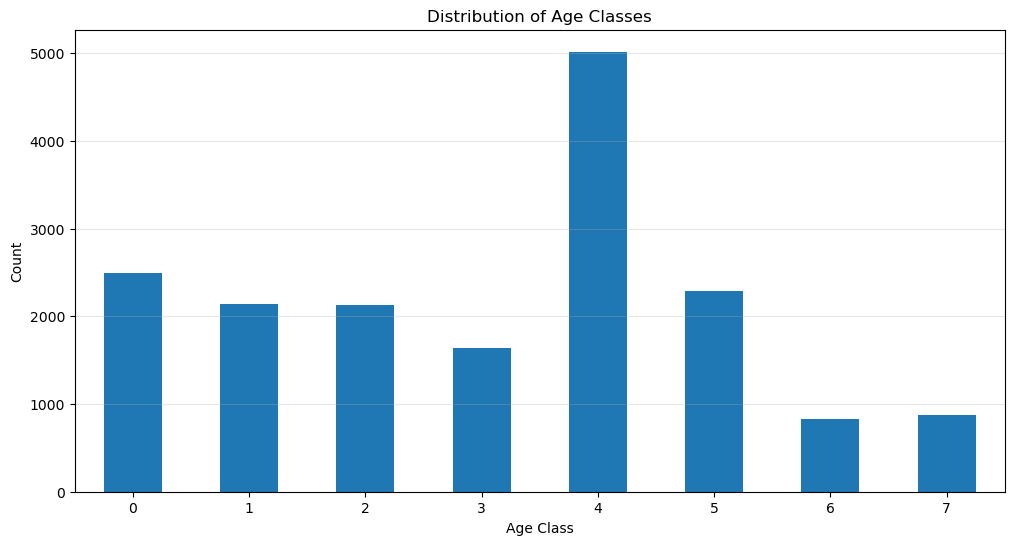

In [35]:
if len(data) > 0:
    print("\nSample data:")
    display(data)
    
    # Show age distribution
    plt.figure(figsize=(12, 6))
    data['age_class'].value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Age Classes')
    plt.xlabel('Age Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

### Extract faces

In [36]:
creator.extract_faces_archive()

data\faces already exists. Skipping extraction.


### Generate dataset

In [37]:
# TODO: Objective function
# if REBUILD_DATASET: 
#     # TODO: Code for deleting the data
#     creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4)
# else:
#     # if exist eller noe
#     creator.download_preprocessed_dataset() # TODO: Google Drive hosting eller noe

creator.create_yolo_dataset(train_folds=[0, 1, 2, 3], val_fold=4, output_dir="data/age_dataset_tune")


✅ data/age_dataset_tune already complete. Skipping...


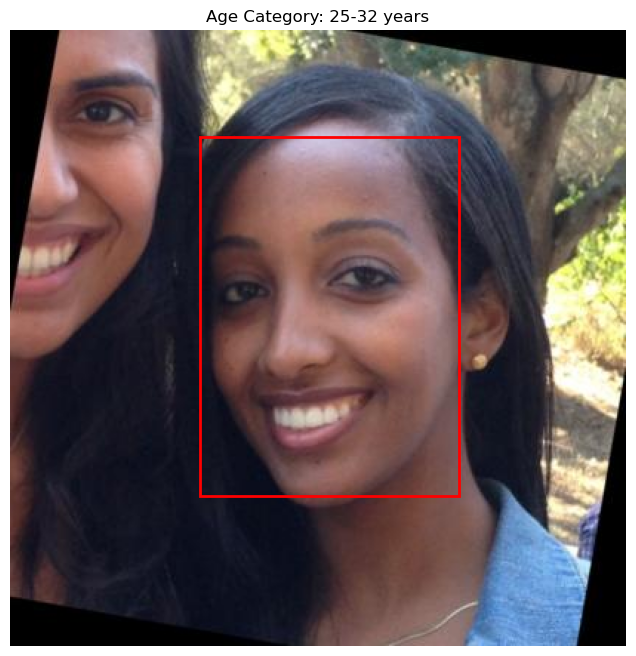

In [38]:
show_sample_with_bbox(img_path='data/age_dataset_test/images/val/5_1327.jpg', label_path='data/age_dataset_test/labels/val/5_1327.txt', creator=creator)

## Hyperparameter tuning

### Tune

In [ ]:
if RUN_OPTUNA:
    run_optuna_tuning_multi(
        base_dataset_dir='data/age_dataset_tune',
        model_sizes=MODEL_SIZES,
        model_versions=MODEL_VERSIONS, 
        imgsz=IMAGE_SIZE,
        n_trials=10 if not SPEEDRUN else 1, # TEMPDEV
        epochs_per_trial=30 if not SPEEDRUN else 1, # TEMPDEV
        device='0',
        output_base='runs/age_exp'
    )
else:
    print("Config RUN_OPTUNA is False")


📂 Evaluating dataset: data/age_dataset_tune\data.yaml

🧪 Tuning: YOLOv8-n on dataset age_dataset_tune
⏩ Skipping tuning: 24 completed trials already (target was 1).

✅ Best result for YOLOv8-n: 0.4656

🧪 Tuning: YOLOv8-s on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-s: 0.1482

🧪 Tuning: YOLOv8-m on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-m: 0.2179

🧪 Tuning: YOLOv8-l on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-l: 0.0086

🧪 Tuning: YOLOv8-x on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv8-x: 0.0000

🧪 Tuning: YOLOv9-n on dataset age_dataset_tune
⏩ Skipping tuning: 1 completed trials already (target was 1).

✅ Best result for YOLOv9-n: 0.0926

🧪 Tuning: YOLOv9-s on dataset age_dataset_tune
⏩ Skipping tuning: 1

[I 2025-04-30 22:59:59,837] A new study created in RDB with name: yolo_v10x


🔄 Starting/resuming tuning: 1 trials needed.
New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov10x.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train45, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:05<00:00, 241.63it/s]


train: New cache created: B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache


train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 3293.08it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.50G reserved, 0.28G allocated, 9.22G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    31670288       72.28         2.206         153.5           nan        (1, 3, 416, 416)                    list
    31670288       144.6         4.068         196.1           nan        (2, 3, 416, 416)                    list
    31670288       289.1         6.034          99.9           nan        (4, 3, 416, 416)                    list
    31670288       578.2        10.865         131.6           nan        (8, 3, 416, 416)                    list
CUDA out of memory. Tried to allocate 34.00 MiB. GPU 0 has a total capacity of 10.00 GiB of which 0 bytes is free. Of the allocated memory 9.12 GiB is allocated by PyTorch, and 173.45 MiB is reserved by PyTorch but unallocated. If rese

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6519.49it/s]


val: Fast image access  (ping: 8.410.5 ms, read: 1.31.0 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6496.00it/s]


optimizer: AdamW(lr=0.010609155653116974, momentum=0.9282598515743892) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.00027899921235165855), 197 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train45
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      3.03G    0.05702      39.45      4.744          5        416: 100%|██████████| 275/275 [01:23<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 368/368 [00:49<00:00,  7.51it/s]


                   all       3679       3679      0.431      0.208     0.0774     0.0333

1 epochs completed in 0.038 hours.
Optimizer stripped from runs\detect\train45\weights\last.pt, 64.1MB
Optimizer stripped from runs\detect\train45\weights\best.pt, 64.1MB

Validating runs\detect\train45\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv10x summary (fused): 192 layers, 29,404,232 parameters, 0 gradients, 160.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 368/368 [00:27<00:00, 13.48it/s]


                   all       3679       3679      0.431       0.21     0.0774     0.0333
Speed: 0.3ms preprocess, 4.1ms inference, 0.0ms loss, 0.2ms postprocess per image


[I 2025-04-30 23:03:25,429] Trial 0 finished with value: 0.03771191427679872 and parameters: {'lr0': 0.010609155653116974, 'lrf': 0.3047944843816231, 'momentum': 0.9282598515743892, 'weight_decay': 0.00027470691677701763, 'warmup_epochs': 5, 'warmup_momentum': 0.7316606437363429, 'box': 0.10195076716965186, 'cls': 2.9232513886538367, 'hsv_h': 0.021784439924342237, 'hsv_s': 0.6687286879191396, 'hsv_v': 0.862386817527838, 'degrees': 12.559604640287926, 'translate': 0.08413580816611743, 'scale': 0.369243751083681, 'fliplr': 0.31856941896654245, 'mosaic': 0.7270372293361731, 'imgsz': 416}. Best is trial 0 with value: 0.03771191427679872.



✅ Best result for YOLOv10-x: 0.0377

🧪 Tuning: YOLOv11-n on dataset age_dataset_tune


[I 2025-04-30 23:03:26,183] A new study created in RDB with name: yolo_v11n


🔄 Starting/resuming tuning: 1 trials needed.
New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6920.76it/s]

AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 1.33G reserved, 0.09G allocated, 8.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


     2591400       2.724         0.833         46.46         280.4        (1, 3, 416, 416)                    list
     2591400       5.449         0.872         40.05         269.6        (2, 3, 416, 416)                    list
     2591400        10.9         1.158         78.37         256.8        (4, 3, 416, 416)                    list
     2591400       21.79         1.581         72.12         266.5        (8, 3, 416, 416)                    list
     2591400       43.59         1.965         73.88         274.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 92 for CUDA:0 9.37G/10.00G (94%) 
train: Fast image access  (ping: 0.10.1 ms, read: 109.87.8 MB/s, size: 20.3 KB)


train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6296.65it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 124.520.9 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6380.38it/s]


optimizer: AdamW(lr=0.0012869062957269973, momentum=0.910144337830089) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0003704106507079885), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train46
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1       5.9G     0.0249      6.154      1.808        159        416: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


                   all       3679       3679    0.00193      0.589     0.0305    0.00505

1 epochs completed in 0.009 hours.
Optimizer stripped from runs\detect\train46\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train46\weights\best.pt, 5.4MB

Validating runs\detect\train46\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11n summary (fused): 100 layers, 2,583,712 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


                   all       3679       3679    0.00193      0.587     0.0306    0.00506
Speed: 0.2ms preprocess, 0.3ms inference, 0.0ms loss, 2.1ms postprocess per image


[I 2025-04-30 23:04:39,280] Trial 0 finished with value: 0.007611651367677352 and parameters: {'lr0': 0.0012869062957269973, 'lrf': 0.5069567706836401, 'momentum': 0.910144337830089, 'weight_decay': 0.00025767697440555725, 'warmup_epochs': 5, 'warmup_momentum': 0.5885364955634527, 'box': 0.11886794104647316, 'cls': 0.9138299224387234, 'hsv_h': 0.09059021352153324, 'hsv_s': 0.7432701257186791, 'hsv_v': 0.511030364057575, 'degrees': 27.032720560461957, 'translate': 0.16449250306131286, 'scale': 0.07769353302757503, 'fliplr': 0.474865811401236, 'mosaic': 0.7646827318369561, 'imgsz': 416}. Best is trial 0 with value: 0.007611651367677352.



✅ Best result for YOLOv11-n: 0.0076

🧪 Tuning: YOLOv11-s on dataset age_dataset_tune


[I 2025-04-30 23:04:40,030] A new study created in RDB with name: yolo_v11s


🔄 Starting/resuming tuning: 1 trials needed.
New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train47, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6021.21it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.84G reserved, 0.14G allocated, 9.01G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9430888       9.111         0.963          53.1         196.6        (1, 3, 416, 416)                    list
     9430888       18.22         1.141         54.92         217.4        (2, 3, 416, 416)                    list
     9430888       36.44         1.621         77.08         225.7        (4, 3, 416, 416)                    list
     9430888       72.88         2.099          81.6         250.9        (8, 3, 416, 416)                    list
     9430888       145.8         3.045         148.4         238.2       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 51 for CUDA:0 8.86G/10.00G (89%) 
train: Fast image access  (ping: 0.10.0 ms, read: 112.64.0

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 7280.84it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 124.726.2 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7342.00it/s]


optimizer: AdamW(lr=0.0030647407310885454, momentum=0.734373543480445) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00045508995308046366), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train47
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.84G    0.02129      5.657      1.901         86        416: 100%|██████████| 27/27 [00:08<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:22<00:00,  1.64it/s]


                   all       3679       3679       0.29      0.114     0.0578     0.0154

1 epochs completed in 0.009 hours.
Optimizer stripped from runs\detect\train47\weights\last.pt, 19.1MB
Optimizer stripped from runs\detect\train47\weights\best.pt, 19.1MB

Validating runs\detect\train47\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:20<00:00,  1.80it/s]


                   all       3679       3679       0.29      0.115     0.0583     0.0155
Speed: 0.2ms preprocess, 0.7ms inference, 0.0ms loss, 2.2ms postprocess per image


[I 2025-04-30 23:05:56,162] Trial 0 finished with value: 0.019766778100737258 and parameters: {'lr0': 0.0030647407310885454, 'lrf': 0.5259671305775608, 'momentum': 0.734373543480445, 'weight_decay': 0.0005710932744539152, 'warmup_epochs': 4, 'warmup_momentum': 0.8882711256605424, 'box': 0.09836577752899996, 'cls': 0.7870181979633426, 'hsv_h': 0.035978791954049814, 'hsv_s': 0.5495400504115365, 'hsv_v': 0.5244108376261624, 'degrees': 36.278274848808856, 'translate': 0.37810768473385703, 'scale': 0.17687192533592505, 'fliplr': 0.04464427393142956, 'mosaic': 0.47751573636654376, 'imgsz': 416}. Best is trial 0 with value: 0.019766778100737258.



✅ Best result for YOLOv11-s: 0.0198

🧪 Tuning: YOLOv11-m on dataset age_dataset_tune


[I 2025-04-30 23:05:56,947] A new study created in RDB with name: yolo_v11m


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 38.8M/38.8M [00:00<00:00, 45.2MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train48, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6555.58it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.59G reserved, 0.22G allocated, 9.18G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    20059176       28.82         1.659         100.4         169.5        (1, 3, 416, 416)                    list
    20059176       57.64         1.984         91.26         193.4        (2, 3, 416, 416)                    list
    20059176       115.3         2.598         84.51         183.4        (4, 3, 416, 416)                    list
    20059176       230.6         3.488         70.32         201.6        (8, 3, 416, 416)                    list
    20059176       461.2         5.583         99.67           180       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 25 for CUDA:0 8.72G/10.00G (87%) 
train: Fast image access  (ping: 0.10.1 ms, read: 107.75.6

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6497.99it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 120.420.6 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7692.87it/s]


optimizer: AdamW(lr=0.0016357965858782865, momentum=0.7953874024046359) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0008611022368344254), 112 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train48
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.85G    0.02878      16.41      1.996         42        416: 100%|██████████| 55/55 [00:14<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:32<00:00,  2.25it/s]


                   all       3679       3679      0.003      0.024    0.00149   0.000382

1 epochs completed in 0.014 hours.
Optimizer stripped from runs\detect\train48\weights\last.pt, 40.5MB
Optimizer stripped from runs\detect\train48\weights\best.pt, 40.5MB

Validating runs\detect\train48\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:29<00:00,  2.48it/s]


                   all       3679       3679     0.0031     0.0245    0.00172   0.000408
Speed: 0.2ms preprocess, 1.6ms inference, 0.0ms loss, 3.9ms postprocess per image


[I 2025-04-30 23:07:41,691] Trial 0 finished with value: 0.0005383530592658577 and parameters: {'lr0': 0.0016357965858782865, 'lrf': 0.6436758451934917, 'momentum': 0.7953874024046359, 'weight_decay': 0.0007348072420987097, 'warmup_epochs': 1, 'warmup_momentum': 0.8907267797936438, 'box': 0.11773553404521218, 'cls': 2.8905419906222525, 'hsv_h': 0.0472536510972167, 'hsv_s': 0.6460936843906351, 'hsv_v': 0.6579669011918357, 'degrees': 21.67511545500313, 'translate': 0.02928129672010993, 'scale': 0.07704425403743137, 'fliplr': 0.14465850336615832, 'mosaic': 0.30940438684426075, 'imgsz': 416}. Best is trial 0 with value: 0.0005383530592658577.



✅ Best result for YOLOv11-m: 0.0005

🧪 Tuning: YOLOv11-l on dataset age_dataset_tune


[I 2025-04-30 23:07:42,488] A new study created in RDB with name: yolo_v11l


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 49.0M/49.0M [00:01<00:00, 41.1MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11l.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train49, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6258.20it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.98G reserved, 0.26G allocated, 8.76G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    25316648       36.89         1.879         141.8         77.91        (1, 3, 416, 416)                    list
    25316648       73.77         2.200         78.13         94.16        (2, 3, 416, 416)                    list
    25316648       147.5         3.146         93.75         125.7        (4, 3, 416, 416)                    list
    25316648       295.1         4.196         109.3         124.4        (8, 3, 416, 416)                    list
    25316648       590.2         6.856           125         109.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 19 for CUDA:0 9.09G/10.00G (91%) 
train: Fast image access  (ping: 0.10.0 ms, read: 112.06.0

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 7305.69it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 108.126.0 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7350.63it/s]


optimizer: AdamW(lr=5.046806689782975e-05, momentum=0.749088167412423) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0002547866902685019), 173 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train49
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.69G   0.009026      10.33      1.631         13        416: 100%|██████████| 73/73 [00:24<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:28<00:00,  3.46it/s]


                   all       3679       3679       0.41     0.0652     0.0535     0.0151

1 epochs completed in 0.016 hours.
Optimizer stripped from runs\detect\train49\weights\last.pt, 51.2MB
Optimizer stripped from runs\detect\train49\weights\best.pt, 51.2MB

Validating runs\detect\train49\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11l summary (fused): 190 layers, 25,285,480 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 97/97 [00:24<00:00,  3.99it/s]


                   all       3679       3679      0.409     0.0654     0.0536     0.0151
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.6ms postprocess per image


[I 2025-04-30 23:09:28,340] Trial 0 finished with value: 0.018993594873106603 and parameters: {'lr0': 5.046806689782975e-05, 'lrf': 0.034131406504622305, 'momentum': 0.749088167412423, 'weight_decay': 0.0002860762838102478, 'warmup_epochs': 5, 'warmup_momentum': 0.6639151034643017, 'box': 0.05166741017103435, 'cls': 2.1906651763956777, 'hsv_h': 0.08877738387144893, 'hsv_s': 0.508272863409278, 'hsv_v': 0.6410274296578125, 'degrees': 5.975748789166946, 'translate': 0.3667992431130573, 'scale': 0.4495685691608404, 'fliplr': 0.023851247192398672, 'mosaic': 0.7936301774077319, 'imgsz': 416}. Best is trial 0 with value: 0.018993594873106603.



✅ Best result for YOLOv11-l: 0.0190

🧪 Tuning: YOLOv11-x on dataset age_dataset_tune


[I 2025-04-30 23:09:29,137] A new study created in RDB with name: yolo_v11x


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 109M/109M [00:02<00:00, 40.4MB/s] 


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11x.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train50, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 5858.14it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.79G reserved, 0.50G allocated, 8.70G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    56883016        82.6         3.334           125         281.3        (1, 3, 416, 416)                    list
    56883016       165.2         3.924           125         329.7        (2, 3, 416, 416)                    list
    56883016       330.4         5.463         171.9         328.1        (4, 3, 416, 416)                    list
    56883016       660.8         7.111         139.9         313.9        (8, 3, 416, 416)                    list
    56883016        1322        11.281         203.1         359.3       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 9 for CUDA:0 9.10G/10.00G (91%) 
train: Fast image access  (ping: 0.10.1 ms, read: 112.57.8 

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6717.13it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 121.423.3 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7315.83it/s]


optimizer: AdamW(lr=0.0006170771979470658, momentum=0.6859166588653411) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00010933110613645203), 173 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train50
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      4.74G    0.03881      11.01      1.874         13        416: 100%|██████████| 153/153 [00:41<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [00:38<00:00,  5.35it/s]


                   all       3679       3679      0.815      0.106     0.0654     0.0203

1 epochs completed in 0.024 hours.
Optimizer stripped from runs\detect\train50\weights\last.pt, 114.4MB
Optimizer stripped from runs\detect\train50\weights\best.pt, 114.4MB

Validating runs\detect\train50\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11x summary (fused): 190 layers, 56,836,264 parameters, 0 gradients, 194.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 205/205 [00:31<00:00,  6.49it/s]


                   all       3679       3679      0.816      0.105     0.0653     0.0203
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 1.6ms postprocess per image


[I 2025-04-30 23:11:59,117] Trial 0 finished with value: 0.024814712238629313 and parameters: {'lr0': 0.0006170771979470658, 'lrf': 0.416206842560447, 'momentum': 0.6859166588653411, 'weight_decay': 0.00011106652051957031, 'warmup_epochs': 2, 'warmup_momentum': 0.5389354315992066, 'box': 0.17536339863124661, 'cls': 2.275153024556152, 'hsv_h': 0.071788906436329, 'hsv_s': 0.5417819918549649, 'hsv_v': 0.8853457538977725, 'degrees': 24.95906720685295, 'translate': 0.021811651422103784, 'scale': 0.08697085884541539, 'fliplr': 0.30747342255382054, 'mosaic': 0.4658261955048658, 'imgsz': 416}. Best is trial 0 with value: 0.024814712238629313.



✅ Best result for YOLOv11-x: 0.0248

🧪 Tuning: YOLOv12-n on dataset age_dataset_tune


[I 2025-04-30 23:12:00,007] A new study created in RDB with name: yolo_v12n


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 5.34M/5.34M [00:00<00:00, 25.5MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo12n.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train51, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6835.99it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 1.83G reserved, 0.09G allocated, 8.07G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2569608       2.741         0.862         66.31         128.4        (1, 3, 416, 416)                    list
     2569608       5.482         0.910         53.03         127.7        (2, 3, 416, 416)                    list
     2569608       10.96         1.206         69.86         115.2        (4, 3, 416, 416)                    list
     2569608       21.93         1.780         69.36         133.9        (8, 3, 416, 416)                    list
     2569608       43.85         2.340         85.17         131.4       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 60 for CUDA:0 8.84G/10.00G (88%) 
train: Fast image access  (ping: 0.10.1 ms, read: 107.77.0

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 5282.50it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 116.123.8 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6188.80it/s]


optimizer: AdamW(lr=0.0002523481010499706, momentum=0.7932633614592878) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0001768312733321732), 119 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train51
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      4.68G   0.008647      7.911      1.723        100        416: 100%|██████████| 23/23 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:20<00:00,  1.52it/s]


                   all       3679       3679    0.00175      0.494    0.00343   0.000506

1 epochs completed in 0.009 hours.
Optimizer stripped from runs\detect\train51\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train51\weights\best.pt, 5.5MB

Validating runs\detect\train51\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv12n summary (fused): 159 layers, 2,558,288 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:18<00:00,  1.68it/s]


                   all       3679       3679    0.00175      0.494    0.00345   0.000506
Speed: 0.2ms preprocess, 0.5ms inference, 0.0ms loss, 1.8ms postprocess per image


[I 2025-04-30 23:13:11,675] Trial 0 finished with value: 0.0008005277132268221 and parameters: {'lr0': 0.0002523481010499706, 'lrf': 0.23997441446144782, 'momentum': 0.7932633614592878, 'weight_decay': 0.00018862002488765142, 'warmup_epochs': 1, 'warmup_momentum': 0.6115448501601445, 'box': 0.04367230308381591, 'cls': 1.3075070352651854, 'hsv_h': 0.014353804073379085, 'hsv_s': 0.5442816922427002, 'hsv_v': 0.7612806157199838, 'degrees': 26.159056134809266, 'translate': 0.18681680672701184, 'scale': 0.2797345588063854, 'fliplr': 0.309321431697288, 'mosaic': 0.5357126775283086, 'imgsz': 416}. Best is trial 0 with value: 0.0008005277132268221.



✅ Best result for YOLOv12-n: 0.0008

🧪 Tuning: YOLOv12-s on dataset age_dataset_tune


[I 2025-04-30 23:13:12,587] A new study created in RDB with name: yolo_v12s


🔄 Starting/resuming tuning: 1 trials needed.
New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo12s.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6740.52it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.51G reserved, 0.14G allocated, 9.34G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     9256232       9.099         1.013         80.21         101.5        (1, 3, 416, 416)                    list
     9256232        18.2         1.200          63.4         114.6        (2, 3, 416, 416)                    list
     9256232        36.4         1.661         84.33           117        (4, 3, 416, 416)                    list
     9256232        72.8         2.370         100.8         116.1        (8, 3, 416, 416)                    list
     9256232       145.6         3.817         87.63         101.1       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 38 for CUDA:0 8.59G/10.00G (86%) 
train: Fast image access  (ping: 0.10.1 ms, read: 104.79.5

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6900.14it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 116.120.2 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7115.69it/s]


optimizer: AdamW(lr=0.0020249262709842617, momentum=0.941139648068583) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0008031084789114506), 119 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train52
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.42G    0.01518      16.62      2.047         11        416: 100%|██████████| 37/37 [00:10<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:26<00:00,  1.84it/s]


                   all       3679       3679    0.00233     0.0442    0.00139   0.000604

1 epochs completed in 0.011 hours.
Optimizer stripped from runs\detect\train52\weights\last.pt, 18.9MB
Optimizer stripped from runs\detect\train52\weights\best.pt, 18.9MB

Validating runs\detect\train52\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv12s summary (fused): 159 layers, 9,233,976 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:23<00:00,  2.08it/s]


                   all       3679       3679    0.00235      0.046    0.00142   0.000653
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 3.2ms postprocess per image


[I 2025-04-30 23:14:36,465] Trial 0 finished with value: 0.0007295688825750511 and parameters: {'lr0': 0.0020249262709842617, 'lrf': 0.503109026881299, 'momentum': 0.941139648068583, 'weight_decay': 0.0006763018769780637, 'warmup_epochs': 4, 'warmup_momentum': 0.6492956218245409, 'box': 0.06430154973429297, 'cls': 2.3925151259225785, 'hsv_h': 0.009890722770299565, 'hsv_s': 0.833737710421574, 'hsv_v': 0.8245860835323624, 'degrees': 29.78520798576811, 'translate': 0.20136738745896188, 'scale': 0.3723048672160944, 'fliplr': 0.4194843903848131, 'mosaic': 0.6281290656784313, 'imgsz': 416}. Best is trial 0 with value: 0.0007295688825750511.



✅ Best result for YOLOv12-s: 0.0007

🧪 Tuning: YOLOv12-m on dataset age_dataset_tune


[I 2025-04-30 23:14:37,244] A new study created in RDB with name: yolo_v12m


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 39.0M/39.0M [00:01<00:00, 35.3MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo12m.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train53, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6276.60it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.55G reserved, 0.23G allocated, 9.23G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    20143656       28.63         1.713         93.79         141.8        (1, 3, 416, 416)                    list
    20143656       57.27         2.032         109.4         120.7        (2, 3, 416, 416)                    list
    20143656       114.5         2.905         111.6         78.16        (4, 3, 416, 416)                    list
    20143656       229.1         3.936         83.04         101.2        (8, 3, 416, 416)                    list
    20143656       458.1         5.927         101.9           110       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 23 for CUDA:0 8.74G/10.00G (87%) 
train: Fast image access  (ping: 0.10.0 ms, read: 109.75.6

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 7337.91it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 105.719.0 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 6530.15it/s]


optimizer: AdamW(lr=0.0003176650737327069, momentum=0.9304536112340448) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0008515796621289891), 129 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train53
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      6.43G   0.003827      8.072      1.634         23        416: 100%|██████████| 60/60 [00:18<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]

                   all       3679       3679      0.242      0.418      0.166     0.0707



1 epochs completed in 0.014 hours.
Optimizer stripped from runs\detect\train53\weights\last.pt, 40.7MB
Optimizer stripped from runs\detect\train53\weights\best.pt, 40.7MB

Validating runs\detect\train53\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv12m summary (fused): 169 layers, 20,111,080 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:24<00:00,  3.30it/s]

                   all       3679       3679      0.242      0.419      0.166     0.0707
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.6ms postprocess per image



[I 2025-04-30 23:16:15,138] Trial 0 finished with value: 0.08025669400150937 and parameters: {'lr0': 0.0003176650737327069, 'lrf': 0.15890563629007134, 'momentum': 0.9304536112340448, 'weight_decay': 0.0007898709909602218, 'warmup_epochs': 4, 'warmup_momentum': 0.7706224698943603, 'box': 0.022422121984111053, 'cls': 1.704275619270925, 'hsv_h': 0.024897454228384686, 'hsv_s': 0.6027245091807052, 'hsv_v': 0.8766388390129938, 'degrees': 8.140738376261337, 'translate': 0.3899374965764964, 'scale': 0.37034254128993005, 'fliplr': 0.12646937047385148, 'mosaic': 0.3343641032713208, 'imgsz': 416}. Best is trial 0 with value: 0.08025669400150937.



✅ Best result for YOLOv12-m: 0.0803

🧪 Tuning: YOLOv12-l on dataset age_dataset_tune


[I 2025-04-30 23:16:15,922] A new study created in RDB with name: yolo_v12l


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 51.2M/51.2M [00:01<00:00, 35.4MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo12l.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train54, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 4203.19it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 0.82G reserved, 0.27G allocated, 8.91G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    26395272       37.79         2.127           152         140.7        (1, 3, 416, 416)                    list
    26395272       75.58         2.611         108.6         183.3        (2, 3, 416, 416)                    list
    26395272       151.2         3.657         157.6           142        (4, 3, 416, 416)                    list
    26395272       302.3         5.207         156.3         165.8        (8, 3, 416, 416)                    list
    26395272       604.6         8.338         178.3         200.9       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 15 for CUDA:0 9.09G/10.00G (91%) 
train: Fast image access  (ping: 0.10.0 ms, read: 85.112.5

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 6651.41it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 105.817.9 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7136.72it/s]


optimizer: AdamW(lr=4.576383219412801e-05, momentum=0.8530176417166953) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0003002980585800919), 211 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train54
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      5.98G    0.01625      6.425      1.781         11        416: 100%|██████████| 92/92 [00:33<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:33<00:00,  3.63it/s]

                   all       3679       3679      0.441      0.478      0.254      0.083



1 epochs completed in 0.020 hours.
Optimizer stripped from runs\detect\train54\weights\last.pt, 53.5MB
Optimizer stripped from runs\detect\train54\weights\best.pt, 53.5MB

Validating runs\detect\train54\weights\best.pt...
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv12l summary (fused): 283 layers, 26,345,240 parameters, 0 gradients, 88.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:27<00:00,  4.40it/s]


                   all       3679       3679       0.44       0.48      0.254     0.0833
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 1.6ms postprocess per image


[I 2025-04-30 23:18:24,470] Trial 0 finished with value: 0.10036229190200036 and parameters: {'lr0': 4.576383219412801e-05, 'lrf': 0.6052257575240506, 'momentum': 0.8530176417166953, 'weight_decay': 0.000320317929152098, 'warmup_epochs': 2, 'warmup_momentum': 0.5762698535893062, 'box': 0.08536027793390921, 'cls': 1.4888115671019182, 'hsv_h': 0.05346261539063373, 'hsv_s': 0.8079242964840485, 'hsv_v': 0.7050567897022606, 'degrees': 27.487529501908263, 'translate': 0.2485114737198189, 'scale': 0.34016621039715056, 'fliplr': 0.024044212204149595, 'mosaic': 0.25324218735550685, 'imgsz': 416}. Best is trial 0 with value: 0.10036229190200036.



✅ Best result for YOLOv12-l: 0.1004

🧪 Tuning: YOLOv12-x on dataset age_dataset_tune


[I 2025-04-30 23:18:25,237] A new study created in RDB with name: yolo_v12x


🔄 Starting/resuming tuning: 1 trials needed.


100%|██████████| 114M/114M [00:03<00:00, 39.5MB/s] 


New https://pypi.org/project/ultralytics/8.3.121 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.119  Python-3.10.17 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo12x.pt, data=data/age_dataset_tune\data.yaml, epochs=1, time=None, patience=100, batch=0.9, imgsz=416, save=True, save_period=-1, cache=disk, device=0, workers=1, project=None, name=train55, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=0.1, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 7489.85it/s]


AutoBatch: Computing optimal batch size for imgsz=416 at 90.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3080) 10.00G total, 1.23G reserved, 0.52G allocated, 8.25G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
    59127624       84.44         3.674         150.8         166.8        (1, 3, 416, 416)                    list
    59127624       168.9         4.547         149.9           250        (2, 3, 416, 416)                    list
    59127624       337.8         6.094         150.3         200.9        (4, 3, 416, 416)                    list
    59127624       675.5         8.233         145.4         203.1        (8, 3, 416, 416)                    list
    59127624        1351        12.067         299.6         571.8       (16, 3, 416, 416)                    list
AutoBatch: Using batch-size 5 for CUDA:0 8.19G/10.00G (82%) 
train: Fast image access  (ping: 0.10.0 ms, read: 110.49.1 

train: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\train.cache... 1373 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1373/1373 [00:00<?, ?it/s]
train: Caching images (0.7GB Disk): 100%|██████████| 1373/1373 [00:00<00:00, 7443.40it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 116.626.8 MB/s, size: 23.3 KB)


val: Scanning B:\OneDrive\Skole\Studier_UiA\8_sem_V25\ikt452_computer_vision\Yolo-Age-estimation\data\age_dataset_tune\labels\val.cache... 3679 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3679/3679 [00:00<?, ?it/s]
val: Caching images (1.8GB Disk): 100%|██████████| 3679/3679 [00:00<00:00, 7203.54it/s]


optimizer: AdamW(lr=1.8205255169970195e-05, momentum=0.6255062337321577) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.00022503189442874138), 211 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 1 dataloader workers
Logging results to runs\detect\train55
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      4.19G    0.03506      8.672       1.67          7        416:  58%|█████▊    | 159/275 [00:50<00:35,  3.26it/s]

### Merge Optuna databases

In [ ]:
source_databases = [
    "sqlite:///YOLO_NB_LOCAL_1.db",
    "sqlite:///YOLO_NB_SERVER.db",
    "sqlite:///YOLO_NB_SERVER_1.db",
    "sqlite:///YOLO.db"
]
target_database = "sqlite:///merged.db"

if MERGE_DB:
    merge_optuna_databases(source_databases, target_database)
    merged_db_paths = ["sqlite:///merged.db"]

    df = extract_study_trials_to_dataframe(merged_db_paths)
    display(df)
else:
    print("Config MERGE_DB is False")


Manual task: Discuss params and set in file

## Train

### Generate training dataset 

With different foldsplit than used in tuning

In [ ]:
creator.create_yolo_dataset(train_folds=[0, 1, 2, 4], val_fold=3, output_dir="data/age_dataset_test")

In [ ]:
default_train_params = {
    'imgsz': 416,
    'optimizer': 'AdamW',
    'val': False,
    'deterministic': False,
    'batch': 32 if not SPEEDRUN or not USE_MAX_BATCH else 0.9, # TEMPDEV
    'workers': 3, # TODO: TEMPDEV
    'fraction': 1.0 if not SPEEDRUN else 0.1 # TEMPDEV
}

### Model Sizes

In [ ]:
if RUN_EXP_MODEL_SIZES:
    for size in MODEL_SIZES:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v='8',
            model_size=size,
            db_path='sqlite:///merged.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 1, # TEMPDEV
            epochs=30 if not SPEEDRUN else 1, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_SIZES is False")

### Data Augmentation

In [ ]:
if RUN_EXP_DATA_AUGMENTATION:
    augmentation_combinations = [
        {
            'hsv_h': 0.015,
            'hsv_s': 0.2,
            'hsv_v': 0.2, 
            'degrees': 20.0,
            'translate': 0.01,
            'scale': 0.2,
            'fliplr': 0.2,
            'mosaic': 0.2
        },
        {
            'hsv_h': 0.02,
            'hsv_s': 0.7,
            'hsv_v': 0.5, 
            'degrees': 35.0,
            'translate': 0.08,
            'scale': 0.4,
            'fliplr': 0.5,
            'mosaic': 0.4
        },
        {
            'hsv_h': 0.03,
            'hsv_s': 0.9,
            'hsv_v': 0.7, 
            'degrees': 50.0,
            'translate': 0.15,
            'scale': 0.6,
            'fliplr': 0.5,
            'mosaic': 0.6
        }
    ]

    for i, combo in enumerate(augmentation_combinations, start=1):
        for close_mosaic_val in [10, 30]:
            experiment_params = {
                **default_train_params,
                **combo,
                'close_mosaic': close_mosaic_val
            }

            print(f"\n=== Running augmentation combo {i} with close_mosaic={close_mosaic_val} ===")

            run_multiple_trainings(
                data_yaml='data/age_dataset_test/data.yaml',
                extra_train_params=experiment_params,
                model_v='8',
                model_size='s',
                db_path='sqlite:///merged.db',
                study_name='3 model size n', # For best params
                num_runs=5 if not SPEEDRUN else 1, # TEMPDEV
                epochs=30 if not SPEEDRUN else 1, # TEMPDEV
                device='0',
                project='runs/multi_runs',
                conf_threshold=0.25
            )
else:
    print("Config RUN_EXP_DATA_AUGMENTATION is False")

### Model Versions

In [ ]:
if RUN_EXP_MODEL_VERSIONS:
    for version in MODEL_VERSIONS:
        run_multiple_trainings(
            data_yaml='data/age_dataset_test/data.yaml',
            extra_train_params=default_train_params,
            model_v=version,
            model_size='s',
            db_path='sqlite:///merged.db',
            study_name='3 model size n', # For best params
            num_runs=5 if not SPEEDRUN else 1, # TEMPDEV
            epochs=30 if not SPEEDRUN else 1, # TEMPDEV
            device='0',
            project='runs/multi_runs',
            conf_threshold=0.25
        )
else:
    print("Config RUN_EXP_MODEL_VERSIONS is False")